# **Acquisition and Reconstruction**
### Assignment 3 : Tomographic reconstrution

The goal of this assignment is to implement a simple version of the tomographic reconstruction, in 2D.

You can use numpy, matplotlib to display your result, and the library you want to open the images (if available via pip install !).
If you want, you can use PyGLM for vector operations, but no other external libraries are authorized.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### I) **Line drawing algorithm (2pts)**

For the reconstruction, we will use a pixel-driven approach (iterating through the pixels of the projection, and for each of them modify the reconstruction.)
To achieve this, we will need a line-drawing algorithm.

**Step 0.0 :** Write a function that take two 2D points as argument and return the coordinates of each cells that are in the path between them. You can look for existing algorithm online (such as Bresenham), but you have to implement it yourself using only Python/Numpy operators.

In [5]:
def path(X1, X2):
  line = []


  if np.abs(X2[1]- X1[1]) < np.abs(X2[0]- X1[0]):

    if X1[0] > X2[0]:
      x1 = X2
      x2 = X1

    else:
      x1 = X1
      x2 = X2

 

    m_new = np.abs(2 *(x2[1] - x1[1]))
    slope_error_new = m_new - np.abs((x2[0] - x1[0]))
    y = x1[1]
    for x in range(x1[0], x2[0]+1) :
      line.append([x,y])
      slope_error_new =slope_error_new + m_new
      if slope_error_new >= 0:
        if x1[1] < x2[1] and y != x2[1]:
          y = y +1
        else:
          if x2[1] != y:
            y = y-1
        slope_error_new =slope_error_new - np.abs(2 * (x2[0] - x1[0]))

  else:

    if X1[1] > X2[1]:
      x1 = X2
      x2 = X1

    else:
      x2 = X2
      x1 = X1



    m_new = np.abs(2 *(x2[0] - x1[0]))
    slope_error_new = m_new - np.abs((x2[1] - x1[1]))
    x = x1[0]
    for y in range(x1[1], x2[1]+1) :
      line.append([x,y])
      slope_error_new =slope_error_new + m_new
      if slope_error_new >= 0:
        if x1[0] < x2[0] and x != x2[0]:
          x = x +1
        else:
          if x != x2[0]:
            x = x-1
        slope_error_new =slope_error_new - np.abs(2 * (x2[1] - x1[1]))


  return line


x2 = [2,5]
x1 = [12,10]
path(x1,x2)


[[2, 5],
 [3, 6],
 [4, 7],
 [5, 7],
 [6, 8],
 [7, 8],
 [8, 9],
 [9, 9],
 [10, 10],
 [11, 10],
 [12, 10]]

**Step 0.1 :** Create a numpy array of size 80 by 80 filled with zeros. Using the previous function, fill the path from \[3,10\] to \[60,75\] with ones and display the result with matplotlib.

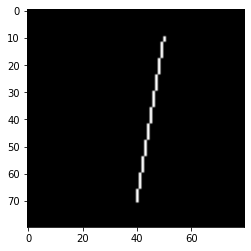

In [6]:
Empty_Image = np.zeros([80,80])
line = path([10,50], [70,40])
for x in line:
  Empty_Image[x[0], x[1]] = 1
plt.imshow(Empty_Image, cmap = plt.cm.gray)


### II) **Parallel 2D reconstruction (3pts + 1pts for performances)**

The reconstructions algorithms are based on two functions : the projection and the backprojection.

The projection is the process done when capturing a radiograph. It reduce the dimension of an object by one (2D->1D or 3D->2D). 

The backprojection is the inverse operation of the projection : it take a projected data and propagate it into a higher dimension object (1D->2D, 2D->3D). Of course, a lot of information is lost in the projection process, so the result of the backprojection carry a less information than the original object. In order to obtain a better approximation, a lot of projections at different positions are needed.

We will only consider the case of circular tomography, where the projections are taken from a single circle around the object. The goal here is to write a backprojector function for various cases : 2D parallel, 2D conical, and 3D conical.

To do this, first, you need to compute for each pixels of the projected data the path in the reconstructed object between the pixel and the source, and add to all element in this path the value of the pixel divided by the length of the path.

For an improved image quality, the path can be also weighted (anti-aliased) to produce a smoother result. In this assignment, you are not asked to do that and can consider all elements in the path to have a weigth of 1.

In the case of a parallel geometry (ie. the rays are all perpendicular to the detector), the voxels have the same size as the pixels, and the distances between the source, the object and the detector don't impact the result.

This type of computations are demanding, espicially in python. Use as much as possible the Numpy functions and try to vectorize your code.

**Step 1.0 :** Open the tiff file "data/sinogram_2d_parallel.tif", store it in a Numpy array, and display it. Each line of the sinogram represent the projection of the image at a given angle.

The parameters of this projections are the following :
 - Parallel aqcuisition geometry
 - 200 projections over 360 degrees (with a regular step)

Each line represent the projection at a specific angle, from 0 to 360°.

33.339058


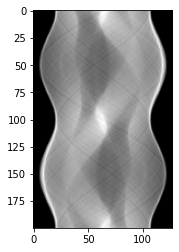

In [ ]:
im = Image.open("sinogram_2d_parallel.tif")
im = np.array(im)
plt.imshow(im, cmap = 'gray')
print(np.amax(im))



**Step 1.1 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end point the path between the pixel determined by (line, angle) and the source, in a parallel geometry.

In [ ]:
r=np.sqrt(im.shape[1])/2

def coord_to_radian(theta):
  return (theta*np.pi/100)

def p1_p2(theta,l):
  theta = coord_to_radian(theta)
  # Source = [-r*np.cos(theta)+(l-64*np.sin(theta)+64,-r*np.sin(theta)-(l-64)*np.cos(theta)+64]
  # d = [np.cos(theta),np.sin(theta)]

  t0x = r - (l-64)*np.sin(theta)/np.cos(theta)-64/np.cos(theta)
  t0y = r + (l-64)*np.cos(theta)/np.sin(theta)-64/np.sin(theta)


  tfx = r - (l-64)*np.sin(theta)/np.cos(theta)+64/np.cos(theta)
  tfy = r + (l-64)*np.cos(theta)/np.sin(theta)+64/np.sin(theta)

  if t0x > tfx:
    pivot = t0x
    t0x = tfx
    tfx = pivot

  if t0y > tfy:
    pivot = t0y
    t0y = tfy
    tfy = pivot


  t_in = max(t0x,t0y)
  t_out = min(tfx,tfy)

  x_in = np.round(-r*np.cos(theta)+(l-64)*np.sin(theta)+64 + t_in*np.cos(theta))
  if x_in == 128:
    x_in = 127
  y_in = np.round(-r*np.sin(theta)-(l-64)*np.cos(theta)+64 + t_in*np.sin(theta))
  if y_in == 128:
    y_in = 127
  x_out = np.round(-r*np.cos(theta)+(l-64)*np.sin(theta)+64 + t_out*np.cos(theta))
  if x_out == 128:
    x_out = 127
  y_out = np.round(-r*np.sin(theta)-(l-64)*np.cos(theta)+64 + t_out*np.sin(theta))
  if y_out == 128:
    y_out = 127

 
  return([(int(x_in),int(y_in)),(int(x_out),int(y_out))])

p1_p2(0,64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


[(0, 64), (127, 64)]

**Step 1.2 :** Using the previous functions, write a 2D backprojector function for parallel geometry, taking as parameters a 2D sinogram and that return the 2D reconstructed image

In [ ]:
def backprojector(sino):
  n = sino.shape[0]
  s = sino.shape[1]

  im = np.zeros([s,s])  

  for i in range(n):
    for j in range(s):

      p = p1_p2(i,j)
      pa = path(p[0],p[1])
      size = len(pa)

      val = sino[i,j]
      for x in pa:
        im[x[0], x[1]] = val/size + im[x[0], x[1]]

  return im

**Step 1.3 :** Apply the parallel reconstruction function to the parallel sinogram and display the result

In [ ]:
im_res = backprojector(im)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


23.290411251812706


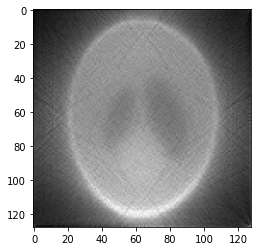

In [ ]:
plt.imshow(np.round(im_res), cmap = 'gray')

### III) **Cone-beam 2D reconstruction (3pts + 1pts for performances)**

The parallel geometry is simpler to reconstruct, but in practice not used so often because of the complexity of the parallel x-ray generation. A much more common approach is to use a ponctual source, that create a cone-beam geometry. 

This mean that the path now come from the source and go to a pixel on the detector, instead of being perpendicular to the detector.

**Step 2.0 :** Open the tiff file "data/sinogram_2d_spherical.tif" and display it.

The parameters of the projection are the following :
 - Spherical aqcuisition geometry
 - 200 projections over 360 degrees
 - source-object distance of 300mm
 - object-detector distance of 400mm
 - Voxel size of 1mm

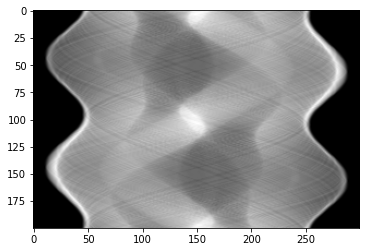

In [8]:
im = Image.open("sinogram_2d_cone.tif")
im = np.array(im)
plt.imshow(im, cmap = 'gray')


**Step 2.1 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end point the path between the pixel determined by (line, angle) and the source, in a cone-beam geometry.

In [9]:
r1 = 400 
r2 = 300
R = r1+r2
d=300
c=128 # taille de l'image supposée carrée
def coord_to_radian(theta):
  return (theta*np.pi/100)

def p1_p2_conebeam(theta,l):
  theta = coord_to_radian(theta)

  t0x = -((c/(2*np.cos(theta))+(d/2)-l-r1)/((d/2)-l-R))
  t0y = -((c/(2*np.sin(theta))+(d/2)-l-r1)/((d/2)-l-R))

  tfx = -((-c/(2*np.cos(theta))+(d/2)-l-r1)/((d/2)-l-R))
  tfy = -((-c/(2*np.sin(theta))+(d/2)-l-r1)/((d/2)-l-R))

  if t0x>tfx:
    pivot=t0x
    t0x=tfx
    tfx=pivot

  if t0y>tfy:
    pivot=t0y
    t0y=tfy
    tfy=pivot

  t_in = max(t0x,t0y)
  t_out = min(tfx,tfy)

  P = np.array([c/2+np.cos(theta)*((d/2)-l-r1),c/2+np.sin(theta)*((d/2)-l-r1)])

  PS= np.array([np.cos(theta)*((d/2)-l-R),np.sin(theta)*((d/2)-l-R)])

  (x_in,y_in) = (np.int(np.round(P+t_in*PS)[0]),np.int(np.round(P+t_in*PS)[1]))
 
  (x_out,y_out) = (np.int(np.round(P+t_out*PS)[0]),np.int(np.round(P+t_out*PS)[1]))
    
  return((x_in,y_in),(x_out,y_out))

**Step 2.2 :** Using the previous functions, write a 2D backprojector function for cone-beam geometry, taking as parameters a 2D sinogram and the geometric parameters, and that return the 2D reconstructed image

In [10]:
def backprojector2(sino):
  n = sino.shape[0]
  s = sino.shape[1]

  im = np.zeros([s,s])  

  for i in range(n):
    for j in range(s):

      p = p1_p2_conebeam(i,j)
      pa = path(p[0],p[1])
      size = len(pa)

      val = sino[i,j]
      for x in pa:
        im[x[0], x[1]] = val/size + im[x[0], x[1]]

  return im

**Step 2.3 :** Apply the spherical reconstruction function to the spherical sinogram and display the result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


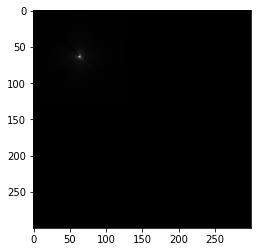

In [11]:
im_res = backprojector2(im)
plt.imshow(np.round(im_res), cmap = 'gray')